# Transfer Learning with ResNet50

# 1. Import Packages and Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.regularizers import l2

2024-07-12 10:09:19.835782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 10:09:19.835896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 10:09:19.970014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 1.1 Dataset

I'll set the seeds to match each other, so the training and validation sets don't overlap. :) 

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/kaggle/input/recyclable-and-household-waste-classification/images/images/"

# Define the training dataset
train_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset='training',
    seed=42
)

# Define the validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset='validation',
    seed=42
)

# Verify the dataset structure
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

for image_batch, label_batch in train_dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Labels: {label_batch.numpy()}")


Found 15000 files belonging to 30 classes.
Using 12000 files for training.
Found 15000 files belonging to 30 classes.
Using 3000 files for validation.
Class names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 30)
Labels: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Now let's take a look at some of the images from the training set: 

In [3]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']
Number of classes: 30


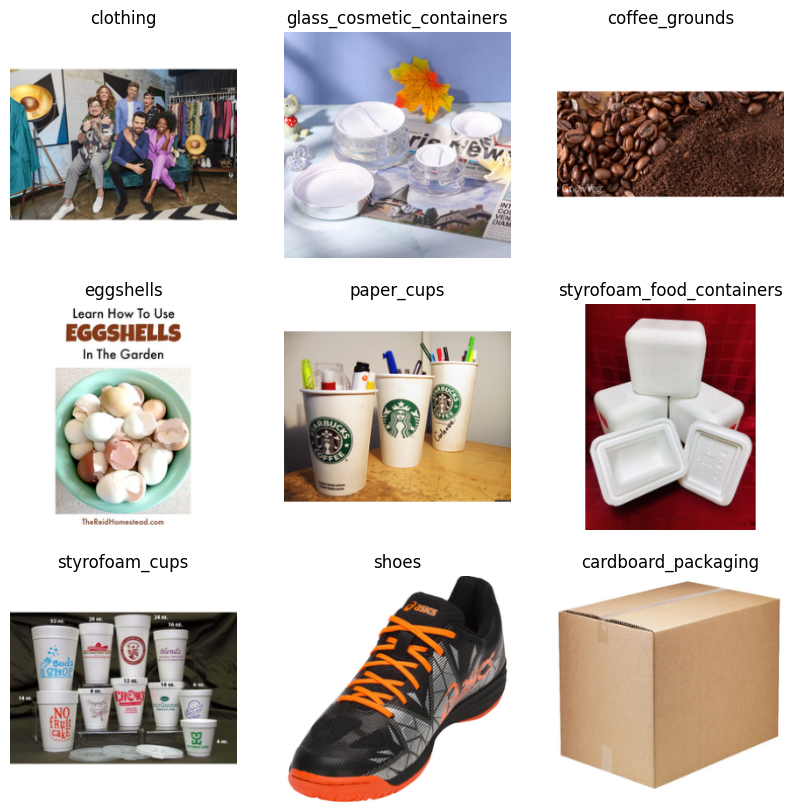

In [4]:
# Verify the dataset structure and plot some examples
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i]).numpy()  # Get the index of the highest value (class)
        plt.title(class_names[label_index])
        plt.axis("off")

plt.show()

# 2. Preprocess and Augment Training Data


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### data_augmenter
a function for data augmentation.

In [6]:

def data_augmenter():
    '''
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(RandomZoom(0.2))
    data_augmentation.add(RandomContrast(0.2))
    
    return data_augmentation

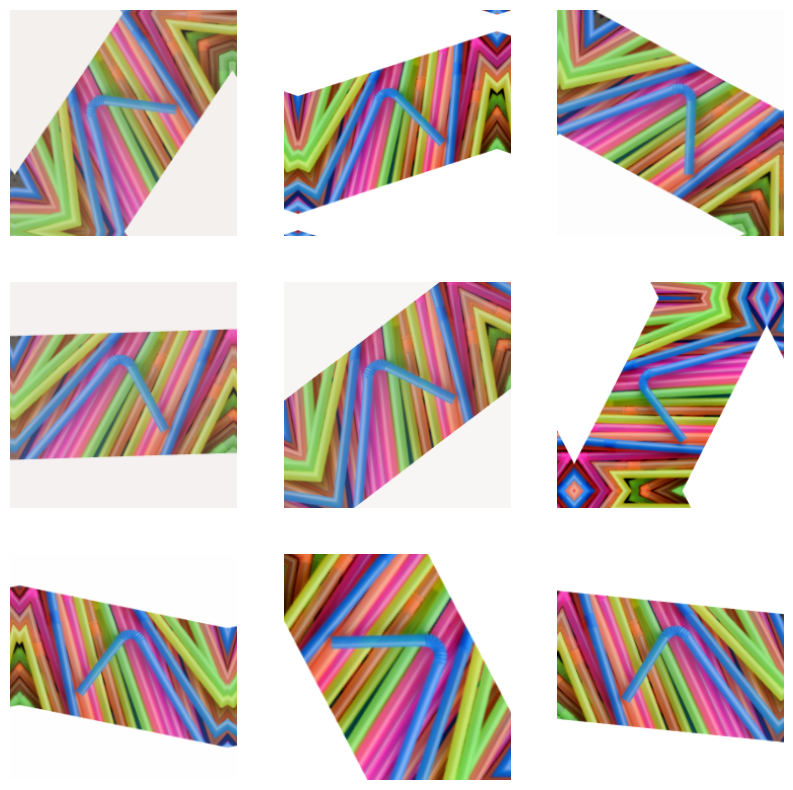

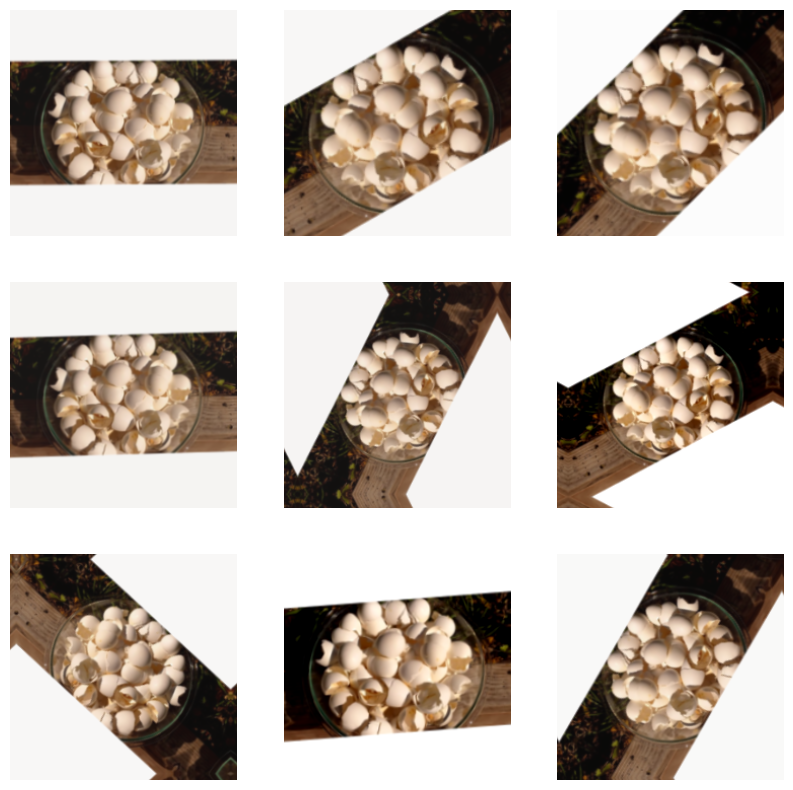

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(2):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Since we're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with `tf.keras.applications.resnet50.preprocess_input`

In [8]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# 3. Import ResNet50 for Transfer Learning

Let's see and try to train our base model using all the layers from the pretrained model. I'll also load the pretrained weights from ImageNet. 

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [11]:
nb_layers = len(base_model.layers)
print('total layers:',nb_layers)
print('second last layer:',base_model.layers[nb_layers - 2].name)
print('last layer:',base_model.layers[nb_layers - 1].name)


total layers: 177
second last layer: avg_pool
last layer: predictions


Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images. 

### 3.1 Layer Freezing with the Functional API

### New_model

In [15]:
num_classes = len(class_names)

def model(image_shape=IMG_SIZE, data_augmentation=data_augmenter(),num_classes=num_classes,dropout_rate=0.4):
    '''
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
        num_classes -- number of category classes
        dropout_rate -- droupout_rate for the classifaction layer
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
        
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new  classification layers
    # global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # dropout layer to avoid overfitting
    x = tfl.Dropout(rate=dropout_rate)(x)
    # a prediction layer with num_classes neurons with l2 regularizer
    outputs = tfl.Dense(units=num_classes,kernel_regularizer=l2(0.01))(x)
    
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

Create our new model using the data_augmentation function defined earlier.

In [16]:
model2 = model(IMG_SIZE, data_augmentation)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


so  now we can go ahead and compile the new model and run it for 5 epochs:

In [17]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 156ms/step - accuracy: 0.3895 - loss: 2.8559 - val_accuracy: 0.7590 - val_loss: 1.2262
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - accuracy: 0.6602 - loss: 1.5408 - val_accuracy: 0.7643 - val_loss: 1.0758
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - accuracy: 0.6900 - loss: 1.3514 - val_accuracy: 0.7880 - val_loss: 1.0013
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - accuracy: 0.7060 - loss: 1.2801 - val_accuracy: 0.7807 - val_loss: 0.9907
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.7084 - loss: 1.2493 - val_accuracy: 0.7937 - val_loss: 0.9840


### 3.2 Plot the training and validation accuracy:

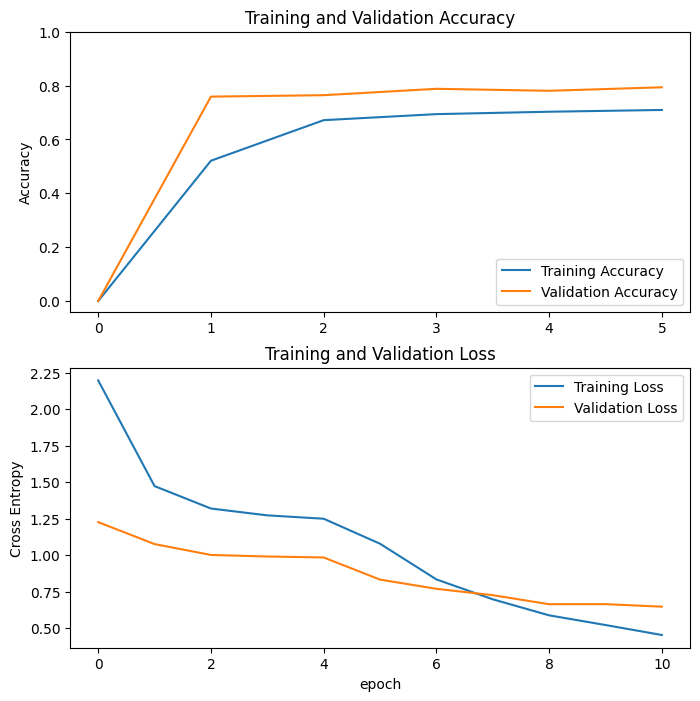

In [29]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
 
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The results are ok, but could be better. Next, try some fine-tuning.

### 3.3 Fine-tuning the Model

We could try fine-tuning the model by re-running the optimizer in the last few layers to improve accuracy.

First, we will unfreeze the base model (resnet50), set a layer to fine-tune from, then re-freeze all the layers before it. We will train it again for another few epochs, and see if the accuracy improved!

In [20]:
# Let's take a look to see how many layers are in the base model
base_model = model2.layers[2]
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [21]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 150

In [22]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a CategoricalCrossentropy loss function.
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']


model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [23]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 88s 199ms/step - accuracy: 0.7390 - loss: 1.1657 - val_accuracy: 0.8307 - val_loss: 0.8323
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.8123 - loss: 0.8750 - val_accuracy: 0.8380 - val_loss: 0.7691
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.8570 - loss: 0.7203 - val_accuracy: 0.8453 - val_loss: 0.7256
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8832 - loss: 0.6015 - val_accuracy: 0.8560 - val_loss: 0.6637
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.9022 - loss: 0.5276 - val_accuracy: 0.8553 - val_loss: 0.6640
Epoch 10/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.9148 - loss: 0.4600 - val_accuracy: 0.8590 - val_loss: 0.6468


Quite an improvement!

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

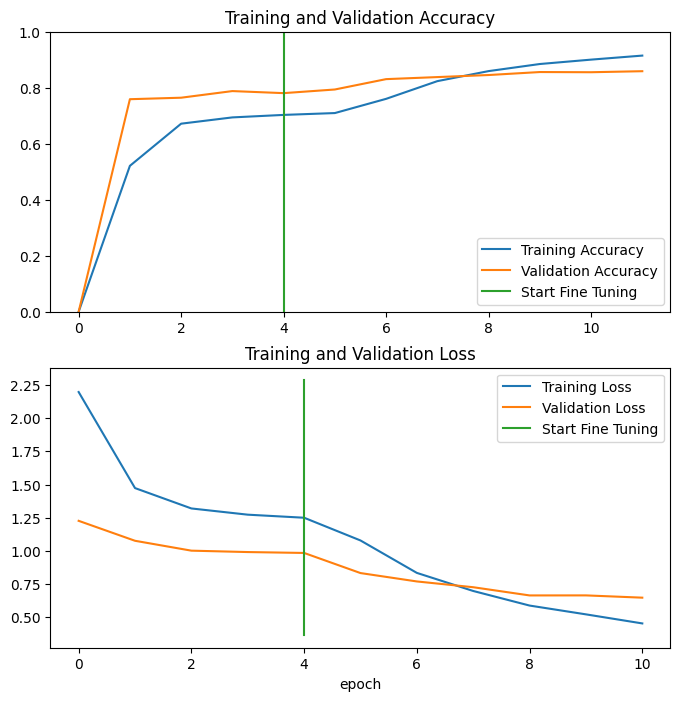

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 4. Prediction
Let's predict some random images from validation dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


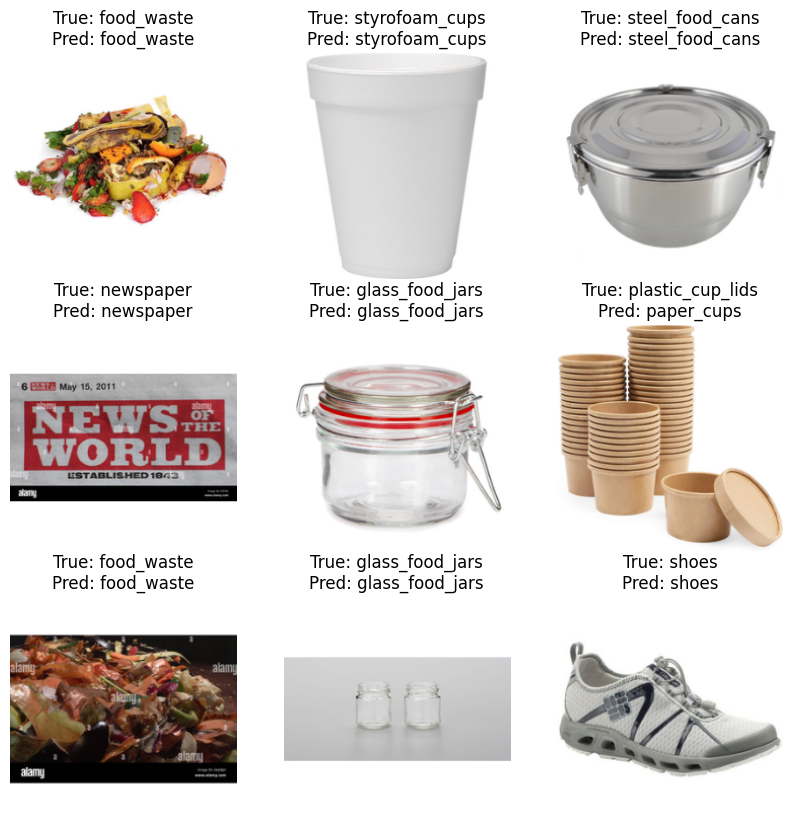

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    # Predict the labels for the batch of images
    predictions = model2.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        true_label_index = tf.argmax(labels[i]).numpy()  # Get the index of the highest value (true class)
        predicted_label_index = predicted_labels[i].numpy()  # Get the index of the highest value (predicted class)
        
        true_label_name = class_names[true_label_index]
        predicted_label_name = class_names[predicted_label_index]
        
        plt.title(f'True: {true_label_name}\nPred: {predicted_label_name}')
        plt.axis("off")

plt.show()

## 4. Save the model 

lets save the model with weights for using in an application

In [27]:
model2.save("/kaggle/working/fine_tuned_resnet50.keras")

Credit: The notebook structure is insprired from this [course](https://www.coursera.org/learn/convolutional-neural-networks)